In [99]:
## Daniel Sandoz, Final Project, Titanic Classification Ensemble ##

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import csv
import time 

# Importing SKLearn clssifiers and libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import preprocessing
from  sklearn.model_selection import train_test_split 
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC


In [7]:
titanic = pd.read_csv("C:/Users/Modeling/Documents/Predictive Models/PM Data/titanictrain.csv", encoding='ISO-8859-1' )

In [5]:
## EDA

In [42]:
# check for missing values
np.sum(titanic.isnull())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
# We have a lot of missing values for age and cabin. It is possible to make 
# the argument to drop cabin, however not for age. We will explore this later.

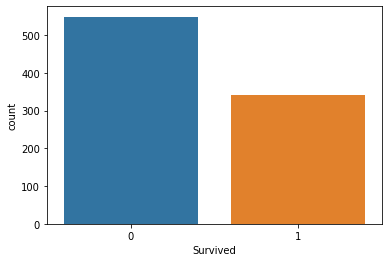

In [43]:
# grasp nature of data: classification
sns.countplot(titanic['Survived'])

In [44]:
titanic.mean()

PassengerId    446.000000
Survived         0.383838
Pclass           2.308642
Age             29.699118
SibSp            0.523008
Parch            0.381594
Fare            32.204208
dtype: float64

In [45]:
# statistics behind the training data
titanic.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Bowen, Mr. David John ""Dai""",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [12]:
# Feature Analysis

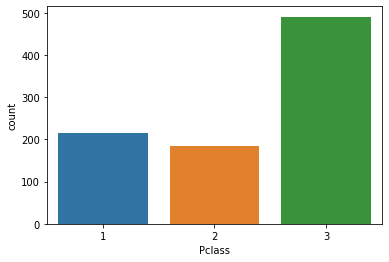

In [7]:
# Class
sns.countplot(titanic['Pclass'])

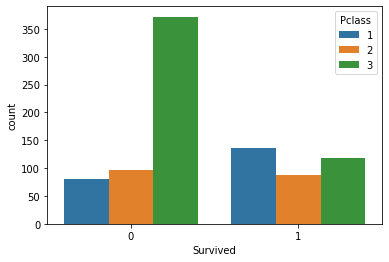

In [8]:
# Class and Survived
sns.countplot(x = 'Survived', hue = 'Pclass', data = titanic)

In [15]:
# It seems like passenger class and survival have a strong relationship. We will explore this later.

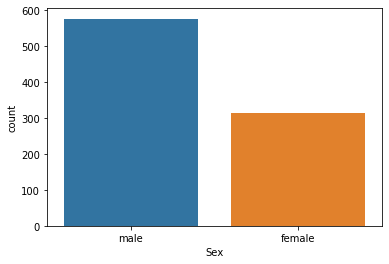

In [9]:
# Sex
sns.countplot(titanic['Sex'])

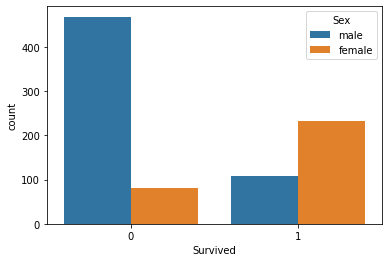

In [10]:
# Sex and Survival
sns.countplot(x = 'Survived', hue = 'Sex', data = titanic)

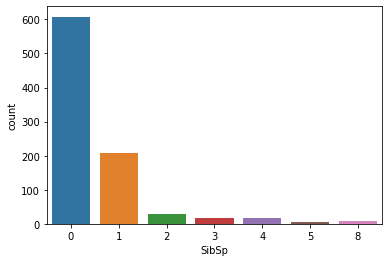

In [11]:
# Sibilings and Spouses
sns.countplot(titanic['SibSp'])

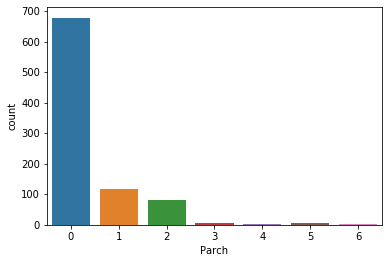

In [12]:
# Parents and Children
sns.countplot(titanic['Parch'])

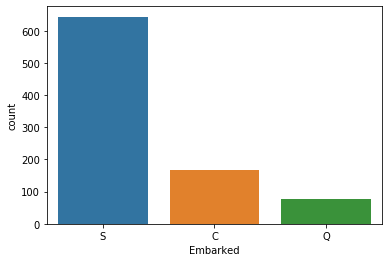

In [13]:
# Embarked: C = Cherbourg, Q = Queenstown, S = Southhampton
sns.countplot(titanic['Embarked'])

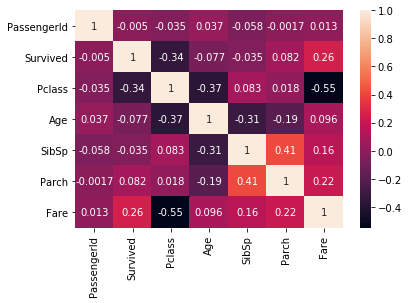

In [14]:
# correaltion analysis
sns.heatmap(titanic.corr(), annot = True)

In [22]:
# There is very low correlation present in the data
# so there is no need to worry about multicollinerity. When considering the 
# issue of missing values for age, the strongest correlation is present
# when age is compared to passenger class. With this, we will use passenger 
# class to help explain age.

In [3]:
age_group = titanic.groupby("Pclass")["Age"]

print(age_group.median())

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64


In [24]:
# After dividing up the passenger class into average ages, it is apparent 
# there is a noteable difference in the average age of each passenger class.
# We can confidently replace age in those groups with the median above.

In [4]:
# Inserting values for age
titanic.loc[titanic.Age.isnull(), 'Age'] = titanic.groupby("Pclass").Age.transform('median')

print(titanic["Age"].isnull().sum())

0


In [8]:
# Check missing values
np.sum(titanic.isnull())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [37]:
# Replace 2 missing values for 'embarked' with 'S' because it occurs the most

In [5]:
from statistics import mode
titanic["Embarked"] = titanic["Embarked"].fillna(mode(titanic["Embarked"]))

In [6]:
# check missing values
np.sum(titanic.isnull())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [ ]:
# Data transformation

In [7]:
# transform sex
titanic["Sex"][titanic["Sex"] == "male"] = 0
titanic["Sex"][titanic["Sex"] == "female"] = 1

C:\Users\Modeling\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Modeling\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# transform embarked
titanic["Embarked"][titanic["Embarked"] == "S"] = 0
titanic["Embarked"][titanic["Embarked"] == "C"] = 1
titanic["Embarked"][titanic["Embarked"] == "Q"] = 2


C:\Users\Modeling\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Modeling\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Modeling\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after r

In [53]:
#show variables by type
titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [9]:
# Here we are dropping "Name", "Ticket", "Passenger ID" and "Cabin" as these are not intuitve
# to analysis, have too many missing values, and/or add the need for more processing resources while not contributing to analysis


titanic = titanic[['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']].copy()
titanic

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,0
1,1,1,1,38.0,1,0,71.2833,1
2,1,3,1,26.0,0,0,7.9250,0
3,1,1,1,35.0,1,0,53.1000,0
4,0,3,0,35.0,0,0,8.0500,0
...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,0
887,1,1,1,19.0,0,0,30.0000,0
888,0,3,1,24.0,1,2,23.4500,0
889,1,1,0,26.0,0,0,30.0000,1


In [10]:
features_train, features_test, target_train, target_test = train_test_split(
    titanic.iloc[:,1:].values, titanic.iloc[:,0].values, test_size=0.4, random_state=0)

In [11]:
# confirm split
print(features_test.shape)
print(features_train.shape)
print(target_test.shape)
print(target_train.shape)

(357, 7)
(534, 7)
(357,)
(534,)


In [ ]:
## KNN ##

In [12]:
knn_df1 = titanic.filter(['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked'].copy(), axis=1)
knn_df2 = titanic['Survived']

In [13]:
# KNN 3
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn = knn.fit(features_train, target_train)


knn_predict = knn.predict(features_test)

In [14]:
# Cross Validation KNN = 3
knn_cross_validate_scores = cross_val_score(knn, features_test, target_test, cv=10)
print('CV Score for each K', knn_cross_validate_scores)
print('CV mean score: ', knn_cross_validate_scores.mean())

CV Score for each K [0.80555556 0.63888889 0.61111111 0.63888889 0.66666667 0.58333333
 0.66666667 0.57142857 0.6        0.68571429]
CV mean score:  0.6468253968253969


In [15]:
# classification and confusion matrix 
print("KNN accuracy score: ",accuracy_score(target_test,knn_predict))
print(classification_report(target_test, knn_predict))
print(confusion_matrix(target_test, knn_predict))

KNN accuracy score:  0.6834733893557423
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       221
           1       0.61      0.48      0.53       136

    accuracy                           0.68       357
   macro avg       0.66      0.64      0.65       357
weighted avg       0.67      0.68      0.67       357

[[179  42]
 [ 71  65]]


In [16]:
# KNN = 5
knn = KNeighborsClassifier(n_neighbors = 5)
knn = knn.fit(features_train, target_train)

# predicting using test set
knn_predict = knn.predict(features_test)

In [17]:
# Cross Validation KNN = 5
knn_cross_validate_scores = cross_val_score(knn, features_test, target_test, cv=10)
print('CV Score for each K', knn_cross_validate_scores)
print('CV mean score: ', knn_cross_validate_scores.mean())

CV Score for each K [0.83333333 0.69444444 0.69444444 0.75       0.66666667 0.61111111
 0.75       0.62857143 0.68571429 0.71428571]
CV mean score:  0.7028571428571428


In [18]:
# classification and confusion matrix 
print("KNN accuracy score: ",accuracy_score(target_test,knn_predict))
print(classification_report(target_test, knn_predict))
print(confusion_matrix(target_test, knn_predict))

KNN accuracy score:  0.711484593837535
              precision    recall  f1-score   support

           0       0.73      0.84      0.78       221
           1       0.66      0.51      0.57       136

    accuracy                           0.71       357
   macro avg       0.70      0.67      0.68       357
weighted avg       0.70      0.71      0.70       357

[[185  36]
 [ 67  69]]


In [19]:
# KNN 7
knn = KNeighborsClassifier(n_neighbors = 7)
knn = knn.fit(features_train, target_train)

# predicting using test set
knn_predict = knn.predict(features_test)

In [20]:
# Cross Validation KNN = 7
knn_cross_validate_scores = cross_val_score(knn, features_test, target_test, cv=10)
print('CV Score for each K', knn_cross_validate_scores)
print('CV mean score: ', knn_cross_validate_scores.mean())

CV Score for each K [0.86111111 0.66666667 0.72222222 0.75       0.69444444 0.61111111
 0.72222222 0.62857143 0.74285714 0.71428571]
CV mean score:  0.7113492063492064


In [21]:
# classification and confusion matrix KNN = 7
print("KNN accuracy score: ",accuracy_score(target_test,knn_predict))
print(classification_report(target_test, knn_predict))
print(confusion_matrix(target_test, knn_predict))

KNN accuracy score:  0.6946778711484594
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       221
           1       0.63      0.47      0.54       136

    accuracy                           0.69       357
   macro avg       0.68      0.65      0.66       357
weighted avg       0.69      0.69      0.68       357

[[184  37]
 [ 72  64]]


In [ ]:
# I ran three different models with n-neighbor classifiers of 3,5 and 7. The
# Knn-5 is the default value for KNN models, however it performed the best.
# We do not have to worry about over fitting with KNN models.
# I saw a slight increase in accuracy for KNN-5 
# vs. KNN-3 and KNN-7. There is also an increase in precision and recall statistics
# for KNN-5 vs. KNN-3 and KNN-7.

In [ ]:
## Decision Tree ##

In [ ]:
# First we will create the default, then fit and test the parameters.

In [22]:
# train DT model
decision_tree = tree.DecisionTreeClassifier()
# fit the DT model
decision_tree = decision_tree.fit(features_train, target_train)
# test the DT model
target_predicted_dt = decision_tree.predict(features_test)

In [23]:
#Cross Validate Default Tree

#verify DT with Cross Validation
scores = cross_val_score(decision_tree, features_train, target_train, cv=10)
print("Cross Validation Score for each K",scores)
print('Cross Validation mean score: ', scores.mean())

Cross Validation Score for each K [0.75925926 0.81481481 0.7962963  0.74074074 0.75471698 0.75471698
 0.64150943 0.81132075 0.71698113 0.8490566 ]
Cross Validation mean score:  0.7639412997903563


In [24]:
#Confusion Matrix Decision Tree

print("Decision Tree accuracy score: ",accuracy_score(target_test,target_predicted_dt))
target_names_dt = ["0", "1"]
print(classification_report(target_test, target_predicted_dt, target_names=target_names_dt))
print(confusion_matrix(target_test, target_predicted_dt, ))

Decision Tree accuracy score:  0.7366946778711485
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       221
           1       0.68      0.60      0.63       136

    accuracy                           0.74       357
   macro avg       0.72      0.71      0.71       357
weighted avg       0.73      0.74      0.73       357

[[182  39]
 [ 55  81]]


In [ ]:
# I created a decision tree from the data. The accuracy of the default model
# is 73.66%. I cross validated with 10 repeats. This default model is 
# better at classifying not survived than survived passengers.

In [26]:
# Decision Tree 2: Max leaf nodes =10, class weight = balanced

# train DT2 model
decision_tree2 = tree.DecisionTreeClassifier(max_leaf_nodes = 10 ,class_weight='balanced')
# fit the DT2 model
decision_tree2 = decision_tree2.fit(features_train, target_train)
# test the DT2 model
target_predicted_dt2 = decision_tree2.predict(features_test)
# verify DT2 with Cross Validation
scores = cross_val_score(decision_tree2, features_train, target_train, cv=10)
print("Cross Validation Score for each K",scores)
print('Cross Validation mean score: ', scores.mean()) 
# confusion matrix DT2
print("Decision Tree2 accuracy score: ",accuracy_score(target_test,target_predicted_dt2))
target_names_dt2 = ["0", "1"]
print(classification_report(target_test, target_predicted_dt2, target_names=target_names_dt2))
print(confusion_matrix(target_test, target_predicted_dt2))

Cross Validation Score for each K [0.77777778 0.88888889 0.77777778 0.77777778 0.86792453 0.77358491
 0.77358491 0.86792453 0.83018868 0.83018868]
Cross Validation mean score:  0.8165618448637316
Decision Tree2 accuracy score:  0.8011204481792717
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       221
           1       0.73      0.76      0.74       136

    accuracy                           0.80       357
   macro avg       0.79      0.79      0.79       357
weighted avg       0.80      0.80      0.80       357

[[183  38]
 [ 33 103]]


In [ ]:
# After viewing the default, I changed some of the parameters adding 
# max leaf nodes = 10, and a balanced weight class in search of getting a 
# stonger model. With the new parameters, the accuracy has increased to
# ~ 80%. Precision, recall, and f-1 have all increased. I will continue to 
# adjust parameters to increase the stregth of the model.

In [37]:
# Decision Tree 3: Max leaf nodes =100, class weight = balanced

# train DT3 model
decision_tree3 = tree.DecisionTreeClassifier(max_leaf_nodes = 100, class_weight = 'balanced')
# fit the DT3 model
decision_tree3 = decision_tree3.fit(features_train, target_train)
# test the DT3 model
target_predicted_dt3 = decision_tree3.predict(features_test)
# verify DT3 with Cross Validation
scores = cross_val_score(decision_tree3, features_train, target_train, cv=10)
print("Cross Validation Score for each K",scores)
print('Cross Validation mean score: ', scores.mean()) 
# confusion matrix DT3
print("Decision Tree2 accuracy score: ",accuracy_score(target_test,target_predicted_dt3))
target_names_dt3 = ["0", "1"]
print(classification_report(target_test, target_predicted_dt3, target_names=target_names_dt3))
print(confusion_matrix(target_test, target_predicted_dt3))

Cross Validation Score for each K [0.75925926 0.83333333 0.85185185 0.7037037  0.79245283 0.77358491
 0.66037736 0.83018868 0.71698113 0.79245283]
Cross Validation mean score:  0.7714185883997204
Decision Tree2 accuracy score:  0.7871148459383753
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       221
           1       0.71      0.74      0.73       136

    accuracy                           0.79       357
   macro avg       0.77      0.78      0.78       357
weighted avg       0.79      0.79      0.79       357

[[180  41]
 [ 35 101]]


In [ ]:
# Because there was only a slight increase in recall, I increased the max leaf
# nodes = 100 and kept the others constant to increase the strength of the model.
# With this, the accuracy has gone down, along with precision and recall statistics.
# Decision Tree 2 seems to currently be the strongest model.

In [47]:
# Grid Search Decision Tree
grid_param = {'min_samples_split': [2, 5, 10, 20],'max_features': [2, 3, 4, 5, 6, 7],'max_leaf_nodes': [10, 30, 75, 100]}

In [48]:
grid_dt = GridSearchCV(decision_tree, param_grid = grid_param, scoring='accuracy',cv=10)
grid_dt.fit(features_train, target_train)

print("BEST ESTM: ",grid_dt.best_estimator_)
print("BEST SCORE: ", grid_dt.best_score_)
print("BEST PARAM: ", grid_dt.best_params_)

BEST ESTM:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=5, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
BEST SCORE:  0.8314116002795249
BEST PARAM:  {'max_features': 5, 'max_leaf_nodes': 10, 'min_samples_split': 10}


In [50]:
# Decision Tree 4: Best

# train DT Best model
decision_tree_best = tree.DecisionTreeClassifier(max_features= 5, max_leaf_nodes= 10, min_samples_split= 10)
# fit the DT Best model
decision_tree_best = decision_tree_best.fit(features_train, target_train)
# test the DT Best model
target_predicted_dtbest = decision_tree_best.predict(features_test)
# verify DT Best with Cross Validation
scores = cross_val_score(decision_tree_best, features_train, target_train, cv=10)
print("Cross Validation Score for each K",scores)
print('Cross Validation mean score: ', scores.mean()) 
# confusion matrix DTBest
print("Decision Tree Best accuracy score: ",accuracy_score(target_test,target_predicted_dtbest))
target_names_dtbest = ["0", "1"]
print(classification_report(target_test, target_predicted_dtbest, target_names=target_names_dtbest))
print(confusion_matrix(target_test, target_predicted_dtbest))

Cross Validation Score for each K [0.7962963  0.90740741 0.81481481 0.7962963  0.83018868 0.73584906
 0.79245283 0.8490566  0.83018868 0.81132075]
Cross Validation mean score:  0.81638714185884
Decision Tree Best accuracy score:  0.8067226890756303
              precision    recall  f1-score   support

           0       0.80      0.92      0.85       221
           1       0.83      0.62      0.71       136

    accuracy                           0.81       357
   macro avg       0.81      0.77      0.78       357
weighted avg       0.81      0.81      0.80       357

[[203  18]
 [ 51  85]]


In [ ]:
# To most successfully tune our hyperparameters, we utilized gridsearch.
# Gridsearch suggested that we use 5 features, 10 leaf nodes, and a min sample
# split of 10. When compared to the Decision Tree 2, the CV mean score, and the
# accuracy score were practically the same. However, the weighed average accuracy
# increased when utilizing gridsearch. Our best decision tree model is model
# number 4

In [265]:
print("Features sorted by their score:")
print("Higher the more important")
print(sorted(zip(map(lambda x: round(x, 7), decision_tree_best.feature_importances_),titanic.columns[1:7]), 
             reverse=True))

Features sorted by their score:
Higher the more important
[(0.6130191, 'Sex'), (0.169758, 'Pclass'), (0.1248619, 'Fare'), (0.092361, 'Age'), (0.0, 'SibSp'), (0.0, 'Parch')]


In [ ]:
# Here we can see the importance of each feature, and how well they add to the 
# proper classification of survivors. It seems that sex is the strongest predictor
# to weather or not a passenger would survive.

In [ ]:
## AdaBoost Decision Tree

In [53]:

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, max_features= 5, max_leaf_nodes= 10, min_samples_split= 10),
                         algorithm="SAMME",
                         n_estimators=200)
bdt.fit(features_train, target_train)
predicted_bdt=bdt.predict(features_test)
expected = target_test
print("Adaboost Accuracy", accuracy_score(expected,predicted_bdt))
print(classification_report(expected, predicted_bdt,target_names=['0', '1']))
print(confusion_matrix(expected, predicted_bdt))

Adaboost Accuracy 0.8235294117647058
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       221
           1       0.80      0.71      0.75       136

    accuracy                           0.82       357
   macro avg       0.82      0.80      0.81       357
weighted avg       0.82      0.82      0.82       357

[[197  24]
 [ 39  97]]


In [ ]:
# After using gridsearch to find the best parameters, I decided to use those
# parameters in combination with the AdaBoost Classifier. This increased the 
# strength of the model across the board. Adaboosted Decision Tree with 
# respective parameters is our preferred Decision Tree model.

In [60]:
print("Features sorted by their score:")
print("Higher the more important")
print(sorted(zip(map(lambda x: round(x, 7), bdt.feature_importances_),titanic.columns[1:5]), 
             reverse=True))

Features sorted by their score:
Higher the more important
[(0.3243417, 'Age'), (0.0797912, 'Sex'), (0.0457439, 'SibSp'), (0.0354762, 'Pclass')]


In [ ]:
# After running feature importance on the preffered Decision Tree model,
# we get a different output regarding the predictive power of each feature.
# This model considers age to be a better explainer of survival vs. sex.  
# However, we have to remember that we grouped age with consideration of the
# passenger class. We will continue to analyze the feature importance to gain
# a better understand on what the major contributors to survival are. 

In [ ]:
## Random Forest

In [56]:
# Default RF
# train RF model
rf = RandomForestClassifier()
# fit the RF model
rf = rf.fit(features_train, target_train)
# test the RF model
target_predicted_rf = rf.predict(features_test)

In [57]:
# Cross validate

scores_rf = cross_val_score(rf, features_train, target_train, cv=10, n_jobs=-1)
print("Cross Validation Score for each K",scores_rf)
print('Cross Validation mean score: ', scores_rf.mean())

Cross Validation Score for each K [0.75925926 0.85185185 0.81481481 0.7962963  0.86792453 0.69811321
 0.71698113 0.81132075 0.81132075 0.83018868]
Cross Validation mean score:  0.7958071278825994


In [58]:
# Confusion matrix

print("Random Forest accuracy score: ",accuracy_score(target_test,target_predicted_rf))
target_names_rf = ["0", "1"]
print(classification_report(target_test, target_predicted_rf, target_names=target_names_rf))
print(confusion_matrix(target_test, target_predicted_rf))

Random Forest accuracy score:  0.8067226890756303
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       221
           1       0.77      0.71      0.74       136

    accuracy                           0.81       357
   macro avg       0.80      0.79      0.79       357
weighted avg       0.80      0.81      0.80       357

[[192  29]
 [ 40  96]]


In [ ]:
# After creating a Random Forest model, the accuracy is ~ 80%, with precision,
# recall, and f-1 scores at 80%, 79%, and 80% respectivly. We will continue
# to adjust hyperparameters in search of increasing these metrics.

In [266]:
# Gridsearch to identify features
# use a full grid over all parameters
param_grid = {"max_features": [2, 3, 4, 5, 6,]}
start_time = time.clock()

# run grid search
grid_search = GridSearchCV(rf, param_grid=param_grid,n_jobs=-1)

grid_search.fit(features_train, target_train)

print("Time to run", time.clock() - start_time, "seconds")
print(grid_search.cv_results_)

C:\Users\Modeling\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


Time to run 2.2537172000156716 seconds
{'mean_fit_time': array([0.21502547, 0.21821699, 0.21941552, 0.231182  , 0.2086484 ]), 'std_fit_time': array([0.00566276, 0.003646  , 0.00296326, 0.00589683, 0.0346643 ]), 'mean_score_time': array([0.01336474, 0.0135632 , 0.01296301, 0.01276565, 0.00917549]), 'std_score_time': array([0.00048856, 0.00048788, 0.00063063, 0.00074648, 0.00193362]), 'param_max_features': masked_array(data=[2, 3, 4, 5, 6],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_features': 2}, {'max_features': 3}, {'max_features': 4}, {'max_features': 5}, {'max_features': 6}], 'split0_test_score': array([0.79439252, 0.80373832, 0.8317757 , 0.81308411, 0.80373832]), 'split1_test_score': array([0.80373832, 0.81308411, 0.80373832, 0.81308411, 0.8411215 ]), 'split2_test_score': array([0.77570093, 0.78504673, 0.76635514, 0.76635514, 0.75700935]), 'split3_test_score': array([0.76635514, 0.76635514, 0.77570093, 0

C:\Users\Modeling\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


In [267]:
#Feature Importance
print("Features sorted by their score:")
print("Higher the more important")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_),titanic.columns[1:100]), 
             reverse=True))

Features sorted by their score:
Higher the more important
[(0.2643, 'Sex'), (0.2611, 'Age'), (0.2551, 'Fare'), (0.0898, 'Pclass'), (0.0532, 'SibSp'), (0.0382, 'Parch'), (0.0382, 'Embarked')]


In [77]:
# Random Forest 2: estimators = 500, jobs =-1, oob score = True

# train RF2 model
rf2 = RandomForestClassifier(n_estimators= 500, n_jobs=-1,oob_score=True)
# fit the RF2 model
rf2 = rf2.fit(features_train, target_train)
# test the RF2 model
target_predicted_rf2 = rf2.predict(features_test)
# cross validate RF2 model
scores_rf2 = cross_val_score(rf2, features_train, target_train, cv=10, n_jobs=-1)
print("Cross Validation Score for each K",scores_rf2)
print('Cross Validation mean score: ', scores_rf2.mean())
# confusion matrix RF2 model
print("Random Forest accuracy score: ",accuracy_score(target_test,target_predicted_rf2))
target_names_rf2 = ["0", "1"]
print(classification_report(target_test, target_predicted_rf2, target_names=target_names_rf2))
print(confusion_matrix(target_test, target_predicted_rf2))

Cross Validation Score for each K [0.74074074 0.87037037 0.81481481 0.77777778 0.8490566  0.71698113
 0.71698113 0.81132075 0.81132075 0.83018868]
Cross Validation mean score:  0.7939552760307478
Random Forest accuracy score:  0.7927170868347339
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       221
           1       0.74      0.70      0.72       136

    accuracy                           0.79       357
   macro avg       0.78      0.77      0.78       357
weighted avg       0.79      0.79      0.79       357

[[188  33]
 [ 41  95]]


In [ ]:
# After increasing the number of bootstrapped trees to 500, jobs =-1, and 
# oob score = true, the model returned a very similar output, however slightly
# decreasing all accuracy statistics.

In [76]:
# Random Forest 3: estimators = 100, jobs =-1, oob score = True


# train RF3 model
rf3 = RandomForestClassifier(n_estimators= 100, n_jobs=-1,oob_score=True)
# fit the RF3 model
rf3 = rf3.fit(features_train, target_train)
# test the RF3 model
target_predicted_rf3 = rf3.predict(features_test)
# cross validate RF3 model
scores_rf3 = cross_val_score(rf3, features_train, target_train, cv=10, n_jobs=-1)
print("Cross Validation Score for each K",scores_rf3)
print('Cross Validation mean score: ', scores_rf3.mean())
# confusion matrix RF3 model
print("Random Forest accuracy score: ",accuracy_score(target_test,target_predicted_rf3))
target_names_rf3 = ["0", "1"]
print(classification_report(target_test, target_predicted_rf3, target_names=target_names_rf3))
print(confusion_matrix(target_test, target_predicted_rf3))

Cross Validation Score for each K [0.75925926 0.85185185 0.81481481 0.77777778 0.8490566  0.73584906
 0.71698113 0.81132075 0.81132075 0.83018868]
Cross Validation mean score:  0.7958420684835779
Random Forest accuracy score:  0.7983193277310925
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       221
           1       0.75      0.71      0.73       136

    accuracy                           0.80       357
   macro avg       0.79      0.78      0.78       357
weighted avg       0.80      0.80      0.80       357

[[189  32]
 [ 40  96]]


In [9]:
# After changing the number of bootstrapped trees to 100, jobs =-1, and 
# oob score = true, the model returned a very similar output to the default,
# however slightly decreasing accuracy and recall statistics.

In [84]:
# Gridsearch Random Forest

param_grid_rf = {'bootstrap': [True],'max_depth': [2, 3, 10, 110],'max_features': [3, 4, 5],'min_samples_leaf': [ 4, 5, 6,],'min_samples_split': [5, 7, 9],'n_estimators': [50, 100]}

In [85]:
grid_rf = GridSearchCV(estimator = rf, param_grid = param_grid_rf, cv = 3, n_jobs = -1, verbose = 2)
grid_rf.fit(features_train, target_train)
print("BEST ESTM: ", grid_rf.best_estimator_)
print("BEST SCORE: ", grid_rf.best_score_)
print("BEST PARAM: ", grid_rf.best_params_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    7.4s


BEST ESTM:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
BEST SCORE:  0.8220973782771536
BEST PARAM:  {'bootstrap': True, 'max_depth': 110, 'max_features': 4, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 50}


[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:   19.6s finished


In [269]:
# Random Forest Best

# train RF Best model
rfbest1 = RandomForestClassifier(bootstrap= True, max_depth= 110, max_features= 4, min_samples_leaf= 5, min_samples_split= 5, n_estimators= 50)
# fit the RF Best model
rfbest = rfbest1.fit(features_train, target_train)
# test the RF Best model
target_predicted_rfbest = rfbest.predict(features_test)
# cross validate RF Best model
scores_rfbest = cross_val_score(rfbest, features_train, target_train, cv=10, n_jobs=-1)
print("Cross Validation Score for each K",scores_rfbest)
print('Cross Validation mean score: ', scores_rfbest.mean()) 

# confusion matrix RF2 model
print("Random Forest accuracy score: ",accuracy_score(target_test,target_predicted_rfbest))
target_names_rfbest = ["0", "1"]
print(classification_report(target_test, target_predicted_rfbest, target_names=target_names_rfbest))
print(confusion_matrix(target_test, target_predicted_rfbest))

Cross Validation Score for each K [0.7962963  0.87037037 0.83333333 0.77777778 0.83018868 0.77358491
 0.77358491 0.86792453 0.83018868 0.8490566 ]
Cross Validation mean score:  0.820230607966457
Random Forest accuracy score:  0.8207282913165266
              precision    recall  f1-score   support

           0       0.82      0.92      0.86       221
           1       0.83      0.66      0.74       136

    accuracy                           0.82       357
   macro avg       0.82      0.79      0.80       357
weighted avg       0.82      0.82      0.82       357

[[203  18]
 [ 46  90]]


In [ ]:
# After using Gridsearch to find the best hyperparameters, we were able to 
# increase our overall accuracy, and accuracy statistics to an accuracy of 
# 82%. We can now inspect what features add the most strength to the 
# strongest model.

In [117]:
# Gridsearch to identify features
# use a full grid over all parameters
param_grid = {"max_features": [2, 3, 4, 5, 6,]}
start_time = time.clock()

# run grid search
grid_search = GridSearchCV(rfbest, param_grid=param_grid,n_jobs=-1)

grid_search.fit(features_train, target_train)

print("Time to run", time.clock() - start_time, "seconds")
print(grid_search.cv_results_)

C:\Users\Modeling\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


Time to run 1.7381523000003654 seconds
{'mean_fit_time': array([0.10691462, 0.10551796, 0.10950618, 0.12785826, 0.13105168]), 'std_fit_time': array([0.00270603, 0.00544163, 0.00603036, 0.01696524, 0.0177803 ]), 'mean_score_time': array([0.00678229, 0.00678215, 0.00698142, 0.00718079, 0.00618081]), 'std_score_time': array([3.98874326e-04, 3.98683676e-04, 1.78416128e-07, 3.99780416e-04,
       1.32348737e-03]), 'param_max_features': masked_array(data=[2, 3, 4, 5, 6],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_features': 2}, {'max_features': 3}, {'max_features': 4}, {'max_features': 5}, {'max_features': 6}], 'split0_test_score': array([0.82242991, 0.82242991, 0.85046729, 0.8411215 , 0.8411215 ]), 'split1_test_score': array([0.81308411, 0.80373832, 0.79439252, 0.81308411, 0.81308411]), 'split2_test_score': array([0.78504673, 0.80373832, 0.80373832, 0.76635514, 0.78504673]), 'split3_test_score': array([0.82242991

C:\Users\Modeling\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


In [118]:
#Feature Importance
print("Features sorted by their score:")
print("Higher the more important")
print(sorted(zip(map(lambda x: round(x, 4), rfbest.feature_importances_),titanic.columns[1:100]), 
             reverse=True))

Features sorted by their score:
Higher the more important
[(0.4755, 'Sex'), (0.1718, 'Fare'), (0.1584, 'Age'), (0.1051, 'Pclass'), (0.0449, 'SibSp'), (0.0299, 'Embarked'), (0.0145, 'Parch')]


In [ ]:
# Here, we can again see that 'sex' is the biggest contributor to whether or
# not an individual survived on the Titanic.

In [ ]:
## AdaBoost Random Forest - takes time to run

In [116]:
# Adaboost (default)
bdt = AdaBoostClassifier((rf),
                         algorithm="SAMME")
bdt.fit(features_train, target_train)
predicted_bdt=bdt.predict(features_test)
expected = target_test
print("Adaboost Accuracy", accuracy_score(expected,predicted_bdt))
print(classification_report(expected, predicted_bdt,target_names=['0', '1']))
print(confusion_matrix(expected, predicted_bdt))

Adaboost Accuracy 0.7955182072829131
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       221
           1       0.74      0.72      0.73       136

    accuracy                           0.80       357
   macro avg       0.78      0.78      0.78       357
weighted avg       0.79      0.80      0.80       357

[[186  35]
 [ 38  98]]


In [115]:
# Adaboost (rfbest)
bdt = AdaBoostClassifier((rfbest),
                         algorithm="SAMME")
bdt.fit(features_train, target_train)
predicted_bdt=bdt.predict(features_test)
expected = target_test
print("Adaboost Accuracy", accuracy_score(expected,predicted_bdt))
print(classification_report(expected, predicted_bdt,target_names=['0', '1']))
print(confusion_matrix(expected, predicted_bdt))

Adaboost Accuracy 0.7759103641456583
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       221
           1       0.71      0.69      0.70       136

    accuracy                           0.78       357
   macro avg       0.76      0.76      0.76       357
weighted avg       0.77      0.78      0.78       357

[[183  38]
 [ 42  94]]


In [ ]:
# After employing Adaboosting Classifier on the default Random Forest, and the 
# best random forest, the accuracy still does not exceed that of the RF Best model.
# The RF best model is the preffered Random Forest model.

In [ ]:
# We can visualie the strength of our RF Best model by plotting a ROC curve

ROC AUC: 0.881


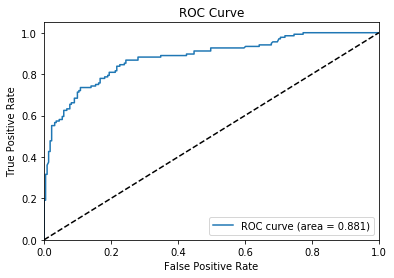

In [120]:
# ROC Curve

# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(target_test, rfbest.predict_proba(features_test)[:,1]) 
    
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print('ROC AUC: %0.3f' % roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# This ROC represent the lift that is present in the Random Forest model.
# With an AUC value reaching close to 1.0 at .881, this acts as an excellent
# classifier.

In [ ]:
## Support Vector Machines - Linear

In [124]:
# train the SVC Linear Default model
svm1 = LinearSVC(class_weight='balanced')
# fit the SVC Linear Default model
svm1 = svm1.fit(features_train, target_train)
# testing the SVC Linear Default model
target_predicted_svm1 = svm1.predict(features_test)
expected = target_test

C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [126]:
# cross validate SVC Linear Default model
start_time = time.clock()
scores_svm1 = cross_val_score(svm1, features_train, target_train, cv=10, scoring='accuracy')
print("Cross Validation Score for each K",scores_svm1)
print('Cross Validation mean score: ', scores_svm1.mean()) 
# confusion matrix SVC Linear Default model
print("SVC Linear 1 accuracy score: ",accuracy_score(target_test,target_predicted_svm1))
target_names_svm1 = ["0", "1"]
print(classification_report(target_test, target_predicted_svm1, target_names=target_names_svm1))
print(confusion_matrix(target_test, target_predicted_svm1))

C:\Users\Modeling\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

Cross Validation Score for each K [0.7037037  0.81481481 0.75925926 0.72222222 0.8490566  0.79245283
 0.37735849 0.79245283 0.79245283 0.75471698]
Cross Validation mean score:  0.7358490566037736
SVC Linear 1 accuracy score:  0.7591036414565826
              precision    recall  f1-score   support

           0       0.85      0.74      0.79       221
           1       0.65      0.79      0.72       136

    accuracy                           0.76       357
   macro avg       0.75      0.77      0.75       357
weighted avg       0.78      0.76      0.76       357

[[163  58]
 [ 28 108]]


C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# Here, we can see that the defult returns a 75% accuracy. We will start to
# adjust the hyperparameters in search of increasing accuracy statistics.

In [127]:
# train the SVC Linear 2 model
svm2 = LinearSVC(class_weight='balanced')
# fit the SVC Linear 2 model
svm2 = svm2.fit(features_train, target_train)
# testing the SVC Linear 2 model
target_predicted_svm2 = svm2.predict(features_test)
expected = target_test

C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [129]:
# cross validate SVC Linear 2 model
start_time = time.clock()
scores_svm2 = cross_val_score(svm2, features_train, target_train, cv=10, scoring='accuracy')
print("Cross Validation Score for each K",scores_svm2)
print('Cross Validation mean score: ', scores_svm2.mean()) 
# confusion matrix SVC Linear 2 model
print("SVC Linear 2 accuracy score: ",accuracy_score(target_test,target_predicted_svm2))
target_names_svm2 = ["0", "1"]
print(classification_report(target_test, target_predicted_svm2, target_names=target_names_svm2))
print(confusion_matrix(target_test, target_predicted_svm2))

C:\Users\Modeling\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

Cross Validation Score for each K [0.77777778 0.83333333 0.74074074 0.74074074 0.73584906 0.77358491
 0.77358491 0.77358491 0.79245283 0.67924528]
Cross Validation mean score:  0.7620894479385046
SVC Linear 2 accuracy score:  0.7703081232492998
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       221
           1       0.72      0.64      0.68       136

    accuracy                           0.77       357
   macro avg       0.76      0.75      0.75       357
weighted avg       0.77      0.77      0.77       357

[[188  33]
 [ 49  87]]


C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# When changing the weight classes to balanced, we were able to increase the
# overall accuracy to 77%, along with recall and f1-score. The precision 
# decreased from 78% to 77%. 
# We will now search to increase the maximum iterations in search of incresing
# accuracy statistics.

In [136]:
# SVC linear, balanced weight, max iterations

# train the SVC Linear  model 3
svm3 = LinearSVC(class_weight='balanced', max_iter = 2500)
# fit the SVC Linear  model 3
svm3 = svm3.fit(features_train, target_train)
# testing the SVC Linear  model 3
target_predicted_svm3 = svm3.predict(features_test)
expected = target_test

C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [137]:
# cross validate SVC Linear model 3
start_time = time.clock()
scores_svm3 = cross_val_score(svm3, features_train, target_train, cv=10, scoring='accuracy')
print("Cross Validation Score for each K",scores_svm3)
print('Cross Validation mean score: ', scores_svm3.mean()) 
# confusion matrix SVC Linear model 3
print("SVC Linear 3 accuracy score: ",accuracy_score(target_test,target_predicted_svm3))
target_names_svm3 = ["0", "1"]
print(classification_report(target_test, target_predicted_svm3, target_names=target_names_svm3))
print(confusion_matrix(target_test, target_predicted_svm3))

C:\Users\Modeling\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

Cross Validation Score for each K [0.7037037  0.87037037 0.81481481 0.7037037  0.81132075 0.77358491
 0.69811321 0.79245283 0.81132075 0.81132075]
Cross Validation mean score:  0.7790705800139761
SVC Linear 3 accuracy score:  0.7787114845938375
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       221
           1       0.69      0.77      0.73       136

    accuracy                           0.78       357
   macro avg       0.77      0.78      0.77       357
weighted avg       0.79      0.78      0.78       357

[[173  48]
 [ 31 105]]


C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# After increasing the maximum iterations up to 2500, from the default 1000,
# we were not only able to increase the overall accuracy of the model, but
# we were also able to bring the precision statistic back up, to 79%, and also 
# increase the recall and f-1 score to 78%. This surpasses the previous manual
# adjustments in the last notebook. SVC linear model 3 is our preffered 
# SVC model.

In [ ]:
# SVC RBF

In [145]:
# SVC RBF default
# train, fit, test SVC model 1
start_time = time.clock()
svm_rbf1 = SVC(kernel='rbf')
print(svm_rbf1)
svm_rbf1.fit(features_train, target_train)
predicted_rbf1=svm_rbf1.predict(features_test)
expected = target_test

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


C:\Users\Modeling\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [146]:
# cross validation and confusion matrix SVC RBF model 1
svm_rbf1_CV_scores = cross_val_score(svm_rbf1, features_train, target_train, cv=10,scoring='accuracy')
print('Cross Validation Score for each K', svm_rbf1_CV_scores)
print('Cross Validation mean score: ', svm_rbf1_CV_scores.mean())

target_names_rbf1 = ["0", "1"]
print(classification_report(expected, predicted_rbf1,target_names=target_names_rbf1))
print(confusion_matrix(expected, predicted_rbf1))
print(accuracy_score(expected,predicted_rbf1))
print("Time to run", time.clock() - start_time, "seconds")

Cross Validation Score for each K [0.72222222 0.64814815 0.7037037  0.68518519 0.67924528 0.67924528
 0.66037736 0.67924528 0.62264151 0.67924528]
Cross Validation mean score:  0.6759259259259259
              precision    recall  f1-score   support

           0       0.68      0.93      0.79       221
           1       0.71      0.29      0.42       136

    accuracy                           0.69       357
   macro avg       0.70      0.61      0.60       357
weighted avg       0.69      0.69      0.64       357

[[205  16]
 [ 96  40]]
0.6862745098039216
Time to run 2.460492800000793 seconds


C:\Users\Modeling\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# The deafult RBF returns a low accuracy of ~ 68%. We will search to increase
# accuracy by tuning hyperparameters

In [174]:
# using grid search to find appropropriate cost function and gamma
start_time = time.clock()

parameters = {'C': [10, 20, 25, 30, 100], 'gamma': [0.001, 0.1], 
              'degree': [0,1,2,3,4,5]}
svr = SVC(kernel='rbf')
grid_svm = GridSearchCV(svm_rbf1, parameters, cv=10)
grid_svm.fit(features_train, target_train)
print("SCORES", grid_svm.cv_results_)
print("BEST SCORE", grid_svm.best_score_)
print("BEST PARAM", grid_svm.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

C:\Users\Modeling\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


SCORES {'mean_fit_time': array([0.00578787, 0.00858023, 0.00508611, 0.00987592, 0.00498779,
       0.00806925, 0.00529153, 0.00867772, 0.00528648, 0.00847278,
       0.00557055, 0.00860002, 0.00547657, 0.00907054, 0.00598922,
       0.00886774, 0.00548518, 0.00867836, 0.00568469, 0.00857813,
       0.00528409, 0.00857661, 0.00518577, 0.00877612, 0.00628283,
       0.00857682, 0.00568457, 0.00867634, 0.00598369, 0.00847704,
       0.00618324, 0.00857673, 0.00578439, 0.00947676, 0.00658472,
       0.00938158, 0.00688062, 0.00987651, 0.00667772, 0.00930479,
       0.00628438, 0.00887167, 0.00628502, 0.0095726 , 0.00687442,
       0.00927792, 0.00667694, 0.00897484, 0.01186862, 0.01126876,
       0.01067271, 0.01216674, 0.01067052, 0.01116889, 0.01096351,
       0.01136925, 0.01077082, 0.01166854, 0.01077089, 0.01126959]), 'std_fit_time': array([4.02071123e-04, 6.66431086e-04, 2.99239254e-04, 1.29684196e-03,
       3.93361755e-06, 3.01712687e-04, 4.53443595e-04, 7.81379834e-04,
       4.58

C:\Users\Modeling\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


In [177]:
# Gridsearch suggest c=100, gamma = .001, degree =0
svm_rbf2 = SVC(kernel='rbf', C=100, degree=0, class_weight='balanced', gamma=0.001)
svm_rbf2.fit(features_train, target_train)
predicted_rbf2=svm_rbf2.predict(features_test)
expected = target_test

# cross validate and confusion matrix SVC RBF model 2
svm_rbf2_CV_scores = cross_val_score(svm_rbf2, features_train, target_train, cv=10,scoring='accuracy')
print('Cross Validation Score for each K', svm_rbf2_CV_scores)
print('Cross Validation mean score: ', svm_rbf2_CV_scores.mean())

target_names_rbf2 = ["0", "1"]
print(classification_report(expected, predicted_rbf2,target_names=target_names_rbf2))
print(confusion_matrix(expected, predicted_rbf2))
print(accuracy_score(expected,predicted_rbf2))
print("Time to run", time.clock() - start_time, "seconds")

Cross Validation Score for each K [0.68518519 0.83333333 0.77777778 0.7037037  0.88679245 0.75471698
 0.75471698 0.83018868 0.83018868 0.83018868]
Cross Validation mean score:  0.7886792452830188
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       221
           1       0.70      0.70      0.70       136

    accuracy                           0.77       357
   macro avg       0.76      0.76      0.76       357
weighted avg       0.77      0.77      0.77       357

[[181  40]
 [ 41  95]]
0.773109243697479
Time to run 130.6817471000013 seconds


C:\Users\Modeling\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  app.launch_new_instance()


In [ ]:
# After using gridsearch to find gamma, cost function, and degree,
# we were able to increase our accuracy significantly to 77%.

In [ ]:
## Artificial Neural Networks / Stochastic Gradient Descent 

In [179]:
from sklearn.neural_network import MLPClassifier

In [100]:
mlp = MLPClassifier(hidden_layer_sizes=(7,7,7))
mlp.fit(features_train,target_train)

C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(7, 7, 7), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [101]:
predictions = mlp.predict(features_test)
print(confusion_matrix(target_test,predictions))
print(classification_report(target_test,predictions))

[[186  35]
 [ 60  76]]
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       221
           1       0.68      0.56      0.62       136

    accuracy                           0.73       357
   macro avg       0.72      0.70      0.71       357
weighted avg       0.73      0.73      0.73       357



In [ ]:
# with defaults(relu,adam) this Ann model employing a stochastic gradient decsent solver (adam) returns an accuracy of 73% when containing
# 7 neurons (n-1 features) at 3 levels. We will continue to adjust the number of neurons and layers to increase accuracy.

In [102]:
# 2 layers, 7 nodes, defaults
mlp = MLPClassifier(hidden_layer_sizes=(7,7))
mlp.fit(features_train,target_train)
predictions = mlp.predict(features_test)
print(confusion_matrix(target_test,predictions))
print(classification_report(target_test,predictions))

[[187  34]
 [ 67  69]]
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       221
           1       0.67      0.51      0.58       136

    accuracy                           0.72       357
   macro avg       0.70      0.68      0.68       357
weighted avg       0.71      0.72      0.71       357



C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
# decreasing the number of layers resulted in a decrease of accuracy when compared
# to default

In [103]:
# 3 layers, 8 nodes, defaults
mlp = MLPClassifier(hidden_layer_sizes=(8,8,8))
mlp.fit(features_train,target_train)
predictions = mlp.predict(features_test)
print(confusion_matrix(target_test,predictions))
print(classification_report(target_test,predictions))

[[189  32]
 [ 41  95]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       221
           1       0.75      0.70      0.72       136

    accuracy                           0.80       357
   macro avg       0.78      0.78      0.78       357
weighted avg       0.79      0.80      0.79       357



C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
#increasing nodes and layers resulted in an increased accuracy.

In [262]:
# 3 layers, 10 nodes, defaults
mlp3 = MLPClassifier(hidden_layer_sizes=(10,10,10))
mlp.fit(features_train,target_train)
predictions = mlp.predict(features_test)
print(confusion_matrix(target_test,predictions))
print(classification_report(target_test,predictions))

[[191  30]
 [ 43  93]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       221
           1       0.76      0.68      0.72       136

    accuracy                           0.80       357
   macro avg       0.79      0.77      0.78       357
weighted avg       0.79      0.80      0.79       357



C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [192]:
# continued increasing of node sizes results in increased accuracy

In [198]:
# 3 layers, 20 nodes, defaults
mlp = MLPClassifier(hidden_layer_sizes=(20,20,20))
mlp.fit(features_train,target_train)
predictions = mlp.predict(features_test)
print(confusion_matrix(target_test,predictions))
print(classification_report(target_test,predictions))

[[181  40]
 [ 34 102]]
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       221
           1       0.72      0.75      0.73       136

    accuracy                           0.79       357
   macro avg       0.78      0.78      0.78       357
weighted avg       0.79      0.79      0.79       357



C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
# I ran five total ANN models. The first default returned a 73% accuracy
# and consisted of 3 layers of 7 nodes.
# After finding that increasing node sizes and number of layers increased accuracy,
# we found the model plateaued after 10 nodes of 3 layers, resulting in an accuracy
# of ~ 80%. Our preffered ANN model consists of 10 nodes at 3 layers.

In [ ]:
## Bagging

In [201]:
# train, fit, test bagging 1 model - default
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier()
print(bag1)
bag.fit(features_train, target_train)
bag_predicted=bag.predict(features_test)
expected = target_test

# cross validation and confusion matrix of bagging model 1
bag_CV_scores = cross_val_score(bag, features_train, target_train, cv=10,scoring='accuracy')
print('Cross Validation Score for each K', bag_CV_scores)
print('Cross Validation mean score: ', bag_CV_scores.mean()) 

print("Bagging Accuracy", accuracy_score(expected,bag_predicted))
print(classification_report(expected, bag_predicted,target_names=["0", "1"]))
print(confusion_matrix(expected, bag_predicted))

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
Cross Validation Score for each K [0.75925926 0.83333333 0.81481481 0.74074074 0.83018868 0.75471698
 0.66037736 0.81132075 0.79245283 0.79245283]
Cross Validation mean score:  0.7789657582110413
Bagging Accuracy 0.7843137254901961
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       221
           1       0.75      0.65      0.70       136

    accuracy                           0.78       357
   macro avg       0.78      0.76      0.76       357
weighted avg       0.78      0.78      0.78       357

[[192  29]
 [ 48  88]]


In [ ]:
# The default bagging classifier resulted in an accuracy and test statistics 
# all equaling 78%. We will work to tune parameters to increase this accuracy.

In [208]:
# 100 estimators, default
clf_bag = BaggingClassifier(n_estimators=100,oob_score=True,n_jobs=-1)
print(clf_bag)
clf_bag.fit(features_train, target_train)
predicted_bag=clf_bag.predict(features_test)
expected = target_test

# cross validation and confusion matrix of bagging model 2
bag_CV_scores = cross_val_score(clf_bag, features_train, target_train, cv=10,scoring='accuracy')
print('Cross Validation Score for each K', bag_CV_scores)
print('Cross Validation mean score: ', bag_CV_scores.mean()) 

print("Bagging Accuracy", accuracy_score(expected,predicted_bag))
print(classification_report(expected, predicted_bag,target_names=["0", "1"]))
print(confusion_matrix(expected, predicted_bag))

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=100,
                  n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                  warm_start=False)
Cross Validation Score for each K [0.75925926 0.85185185 0.87037037 0.75925926 0.79245283 0.75471698
 0.73584906 0.81132075 0.75471698 0.79245283]
Cross Validation mean score:  0.7882250174703005
Bagging Accuracy 0.8011204481792717
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       221
           1       0.77      0.68      0.72       136

    accuracy                           0.80       357
   macro avg       0.79      0.78      0.78       357
weighted avg       0.80      0.80      0.80       357

[[193  28]
 [ 43  93]]


In [ ]:
# when adding 100 estimators, out of bag score - true, jobs =-1,
# the accuracy increases to 80% across weighted average of all metrics. 

In [211]:
# 1000 estimators, oob score = true, n jobs = -1

clf_bag3 = BaggingClassifier(n_estimators=1000,oob_score=True,n_jobs=-1)
print(clf_bag3)
clf_bag3.fit(features_train, target_train)
predicted_bag=clf_bag3.predict(features_test)
expected = target_test

# cross validation and confusion matrix of bagging model 3
bag_CV_scores3 = cross_val_score(clf_bag3, features_train, target_train, cv=10,scoring='accuracy')
print('Cross Validation Score for each K', bag_CV_scores3)
print('Cross Validation mean score: ', bag_CV_scores3.mean()) 

print("Bagging Accuracy", accuracy_score(expected,predicted_bag))
print(classification_report(expected, predicted_bag,target_names=["0", "1"]))
print(confusion_matrix(expected, predicted_bag))

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=1000,
                  n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                  warm_start=False)
Cross Validation Score for each K [0.74074074 0.85185185 0.85185185 0.75925926 0.79245283 0.79245283
 0.71698113 0.81132075 0.75471698 0.81132075]
Cross Validation mean score:  0.7882948986722571
Bagging Accuracy 0.8011204481792717
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       221
           1       0.77      0.68      0.72       136

    accuracy                           0.80       357
   macro avg       0.79      0.78      0.78       357
weighted avg       0.80      0.80      0.80       357

[[193  28]
 [ 43  93]]


In [ ]:
# I ran three bagging classifiers on the data. The default retuned an accuracy of 78%
# After adjusting the number of estimators, oob score = true, n_jobs =-1,
# the model was able to increase accuracy and recall statistics. 
# We then increased the number of estimators to 1000. This only increased the
# run time of the model, and did not result in an increased accuracy.
# Our preffered bagging model consists of 100 estimators, n_jobs =-1, oobscore = true.

In [ ]:
## Gradient Boosting

In [213]:
# default graident boosting
from sklearn.ensemble import GradientBoostingClassifier
gbc1 = GradientBoostingClassifier()
print(GradientBoostingClassifier())
gbc1.fit(features_train, target_train)
gbc1_predicted = gbc1.predict(features_test)
expected = target_test

# cross validation and confusion matrix of gradient boosting model 1
gbc1_CV_scores = cross_val_score(gbc1, features_train, target_train, cv=10,scoring='accuracy')
print('Cross Validation Score for each K', gbc1_CV_scores)
print('Cross Validation mean score: ', gbc1_CV_scores.mean())

print("Gradient Boost Accuracy", accuracy_score(expected,gbc1_predicted))
print(classification_report(expected, gbc1_predicted,target_names=["0", "1"]))
print(confusion_matrix(expected, gbc1_predicted))


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Cross Validation Score for each K [0.81481481 0.85185185 0.81481481 0.75925926 0.86792453 0.79245283
 0.81132075 0.90566038 0.81132075 0.83018868]
Cross Validation mean score:  0.8259608665269044
Gradient Boost Accuracy 0.8095238095238095
              precision    recall  f1-score   support

         

In [ ]:
# Our default gradient boosting classifier returned an accuracy and 
# all recall statistics at 81%. We will work to turne hyperparameters in
# search of increasing accuracy.

In [214]:
# train, fit, test gradient boosting 2 model; estimators = 500
gbc2 = GradientBoostingClassifier(n_estimators=500)
gbc2.fit(features_train, target_train)
gbc2_predicted = gbc2.predict(features_test)
expected = target_test

# cross validation and confusion matrix of gradient boosting model 2
gbc2_CV_scores = cross_val_score(gbc2, features_train, target_train, cv=10,scoring='accuracy')
print('Cross Validation Score for each K', gbc2_CV_scores)
print('Cross Validation mean score: ', gbc2_CV_scores.mean())

print("Gradient Boost Accuracy", accuracy_score(expected,gbc2_predicted))
print(classification_report(expected, gbc2_predicted,target_names=["0", "1"]))
print(confusion_matrix(expected, gbc2_predicted))

Cross Validation Score for each K [0.7962963  0.87037037 0.83333333 0.77777778 0.90566038 0.81132075
 0.79245283 0.81132075 0.81132075 0.8490566 ]
Cross Validation mean score:  0.8258909853249475
Gradient Boost Accuracy 0.7899159663865546
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       221
           1       0.75      0.67      0.71       136

    accuracy                           0.79       357
   macro avg       0.78      0.77      0.77       357
weighted avg       0.79      0.79      0.79       357

[[191  30]
 [ 45  91]]


In [215]:
# train, fit, test gradient boosting 3 model; learing rate=.5, estimators = 500
from sklearn.ensemble import GradientBoostingClassifier
gbc3 = GradientBoostingClassifier(learning_rate=.5,n_estimators=500)
gbc3.fit(features_train, target_train)
gbc3_predicted = gbc3.predict(features_test)
expected = target_test

# cross validation and confusion matrix of gradient boosting model 3
gbc3_CV_scores = cross_val_score(gbc3, features_train, target_train, cv=10,scoring='accuracy')
print('Cross Validation Score for each K', gbc3_CV_scores)
print('Cross Validation mean score: ', gbc3_CV_scores.mean())

print("Gradient Boost Accuracy", accuracy_score(expected,gbc3_predicted))
print(classification_report(expected, gbc3_predicted,target_names=["0", "1"]))
print(confusion_matrix(expected, gbc3_predicted))

Cross Validation Score for each K [0.81481481 0.87037037 0.7962963  0.81481481 0.88679245 0.77358491
 0.79245283 0.75471698 0.81132075 0.83018868]
Cross Validation mean score:  0.8145352900069882
Gradient Boost Accuracy 0.7927170868347339
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       221
           1       0.74      0.70      0.72       136

    accuracy                           0.79       357
   macro avg       0.78      0.77      0.78       357
weighted avg       0.79      0.79      0.79       357

[[188  33]
 [ 41  95]]


In [ ]:
# After adding estimators and learning rate, we were not able to increase our accuracy
# We will continute to adjust these in search of increasing accuracy

In [218]:
# train, fit, test gradient boosting 4 model; learing rate=.1, estimators = 500
from sklearn.ensemble import GradientBoostingClassifier
gbc4 = GradientBoostingClassifier(learning_rate=.1,n_estimators=500)
gbc4.fit(features_train, target_train)
gbc4_predicted = gbc4.predict(features_test)
expected = target_test

# cross validation and confusion matrix of gradient boosting model 3
gbc4_CV_scores = cross_val_score(gbc4, features_train, target_train, cv=10,scoring='accuracy')
print('Cross Validation Score for each K', gbc4_CV_scores)
print('Cross Validation mean score: ', gbc4_CV_scores.mean())

print("Gradient Boost Accuracy", accuracy_score(expected,gbc4_predicted))
print(classification_report(expected, gbc4_predicted,target_names=["0", "1"]))
print(confusion_matrix(expected, gbc4_predicted))

Cross Validation Score for each K [0.7962963  0.87037037 0.83333333 0.77777778 0.90566038 0.81132075
 0.79245283 0.81132075 0.81132075 0.8490566 ]
Cross Validation mean score:  0.8258909853249475
Gradient Boost Accuracy 0.7927170868347339
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       221
           1       0.75      0.68      0.71       136

    accuracy                           0.79       357
   macro avg       0.78      0.77      0.78       357
weighted avg       0.79      0.79      0.79       357

[[191  30]
 [ 44  92]]


In [219]:
# train, fit, test gradient boosting 5 model; learing rate=.1, estimators = 1000
from sklearn.ensemble import GradientBoostingClassifier
gbc5 = GradientBoostingClassifier(learning_rate=.1,n_estimators=1000)
gbc5.fit(features_train, target_train)
gbc5_predicted = gbc5.predict(features_test)
expected = target_test

# cross validation and confusion matrix of gradient boosting model 3
gbc5_CV_scores = cross_val_score(gbc5, features_train, target_train, cv=10,scoring='accuracy')
print('Cross Validation Score for each K', gbc5_CV_scores)
print('Cross Validation mean score: ', gbc5_CV_scores.mean())

print("Gradient Boost Accuracy", accuracy_score(expected,gbc5_predicted))
print(classification_report(expected, gbc5_predicted,target_names=["0", "1"]))
print(confusion_matrix(expected, gbc5_predicted))

Cross Validation Score for each K [0.81481481 0.87037037 0.83333333 0.7962963  0.88679245 0.77358491
 0.79245283 0.79245283 0.81132075 0.86792453]
Cross Validation mean score:  0.8239343116701606
Gradient Boost Accuracy 0.7983193277310925
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       221
           1       0.76      0.69      0.72       136

    accuracy                           0.80       357
   macro avg       0.79      0.78      0.78       357
weighted avg       0.80      0.80      0.80       357

[[191  30]
 [ 42  94]]


In [ ]:
# I ran 5 gradient boosting models on the data. The default returned an accuracy of 81
# and all recall statistics of 81% as well. We looked to adjust hyperparameters
# in search of increasing accuracy.
# After adjusting the learning rate and number of estimators, we were unable to increase our accuracy.
# Our preffered Gradient Boosting Classifier was the deafult with max_features=1.0, max_samples=1.0, n_estimators=10,
# n_jobs=None, oob_score=False, random_state=None, verbose=0

In [ ]:
## Extra Trees

In [231]:
# extra trees default
from sklearn.ensemble import ExtraTreesClassifier
xdt = ExtraTreesClassifier(n_estimators=100, criterion='gini', max_depth=None, 
                           min_samples_split=2, min_samples_leaf=1, 
                           min_weight_fraction_leaf=0.0, max_features='auto', 
                           max_leaf_nodes=None, min_impurity_decrease=0.0, 
                           min_impurity_split=None, bootstrap=False, oob_score=False,
                           n_jobs=None, random_state=None, verbose=0, warm_start=False,
                           class_weight=None, ccp_alpha=0.0, max_samples=None)
xdt.fit(features_train, target_train)
predicted_xdt=xdt.predict(features_test)
expected = target_test

# cross validation and confusion matrix of extra trees default
xdt_CV_scores = cross_val_score(xdt, features_train, target_train, cv=10,scoring='accuracy')
print('Cross Validation Score for each K', xdt_CV_scores)
print('Cross Validation mean score: ', xdt_CV_scores.mean())

print("Gradient Boost Accuracy", accuracy_score(expected,predicted_xdt))
print(classification_report(expected, predicted_xdt,target_names=["0", "1"]))
print(confusion_matrix(expected, predicted_xdt))





Cross Validation Score for each K [0.74074074 0.81481481 0.81481481 0.7962963  0.86792453 0.67924528
 0.69811321 0.83018868 0.75471698 0.83018868]
Cross Validation mean score:  0.7827044025157233
Gradient Boost Accuracy 0.7787114845938375
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       221
           1       0.72      0.69      0.70       136

    accuracy                           0.78       357
   macro avg       0.77      0.76      0.76       357
weighted avg       0.78      0.78      0.78       357

[[184  37]
 [ 42  94]]


In [ ]:
# The Extra Trees Classifier default returned an accuracy of 78%, along with recall
# statistics equalling 78% as well. We will adjust the hyperparameters in
# search of increasing accuracy and recall statistics.

In [232]:
# Extra trees model 2, max depth =5, weight = balanced
xdt = ExtraTreesClassifier(max_depth=5,
                         n_estimators=100,class_weight='balanced')
xdt.fit(features_train, target_train)
predicted_xdt=xdt.predict(features_test)
expected = target_test

# cross validation and confusion matrix of extra trees model 2
xdt_CV_scores = cross_val_score(xdt, features_train, target_train, cv=10,scoring='accuracy')
print('Cross Validation Score for each K', xdt_CV_scores)
print('Cross Validation mean score: ', xdt_CV_scores.mean())

print("Gradient Boost Accuracy", accuracy_score(expected,predicted_xdt))
print(classification_report(expected, predicted_xdt,target_names=["0", "1"]))
print(confusion_matrix(expected, predicted_xdt))



Cross Validation Score for each K [0.74074074 0.85185185 0.81481481 0.74074074 0.8490566  0.75471698
 0.81132075 0.86792453 0.81132075 0.83018868]
Cross Validation mean score:  0.807267645003494
Gradient Boost Accuracy 0.7927170868347339
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       221
           1       0.74      0.70      0.72       136

    accuracy                           0.79       357
   macro avg       0.78      0.77      0.78       357
weighted avg       0.79      0.79      0.79       357

[[188  33]
 [ 41  95]]


In [234]:
# Extra trees model 3, max depth =3, weight = balanced
xdt = ExtraTreesClassifier(max_depth=3,
                         n_estimators=100,class_weight='balanced')
xdt.fit(features_train, target_train)
predicted_xdt=xdt.predict(features_test)
expected = target_test

# cross validation and confusion matrix of extra trees model 3
xdt_CV_scores = cross_val_score(xdt, features_train, target_train, cv=10,scoring='accuracy')
print('Cross Validation Score for each K', xdt_CV_scores)
print('Cross Validation mean score: ', xdt_CV_scores.mean())

print("Gradient Boost Accuracy", accuracy_score(expected,predicted_xdt))
print(classification_report(expected, predicted_xdt,target_names=["0", "1"]))
print(confusion_matrix(expected, predicted_xdt))


Cross Validation Score for each K [0.74074074 0.85185185 0.7962963  0.72222222 0.83018868 0.77358491
 0.79245283 0.8490566  0.81132075 0.83018868]
Cross Validation mean score:  0.7997903563941299
Gradient Boost Accuracy 0.7871148459383753
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       221
           1       0.73      0.70      0.71       136

    accuracy                           0.79       357
   macro avg       0.78      0.77      0.77       357
weighted avg       0.79      0.79      0.79       357

[[186  35]
 [ 41  95]]


In [ ]:
# Decreasing the depth resulted in a decrease in accuracy.

In [235]:
# Extra trees model 4, max depth =5, weight = balanced, estimators = 1000
xdt = ExtraTreesClassifier(max_depth=5,
                         n_estimators=1000,class_weight='balanced')
xdt.fit(features_train, target_train)
predicted_xdt=xdt.predict(features_test)
expected = target_test

# cross validation and confusion matrix of extra trees model 4
xdt_CV_scores = cross_val_score(xdt, features_train, target_train, cv=10,scoring='accuracy')
print('Cross Validation Score for each K', xdt_CV_scores)
print('Cross Validation mean score: ', xdt_CV_scores.mean())

print("Gradient Boost Accuracy", accuracy_score(expected,predicted_xdt))
print(classification_report(expected, predicted_xdt,target_names=["0", "1"]))
print(confusion_matrix(expected, predicted_xdt))

Cross Validation Score for each K [0.7037037  0.85185185 0.81481481 0.74074074 0.8490566  0.77358491
 0.81132075 0.8490566  0.83018868 0.81132075]
Cross Validation mean score:  0.8035639412997904
Gradient Boost Accuracy 0.7899159663865546
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       221
           1       0.74      0.69      0.71       136

    accuracy                           0.79       357
   macro avg       0.78      0.77      0.77       357
weighted avg       0.79      0.79      0.79       357

[[188  33]
 [ 42  94]]


In [238]:
# Extra trees model 5, max depth =10, weight = balanced, estimators = 500
xdt = ExtraTreesClassifier(max_depth=10,
                         n_estimators=100,class_weight='balanced')
xdt.fit(features_train, target_train)
predicted_xdt=xdt.predict(features_test)
expected = target_test

# cross validation and confusion matrix of extra trees model 5
xdt_CV_scores = cross_val_score(xdt, features_train, target_train, cv=10,scoring='accuracy')
print('Cross Validation Score for each K', xdt_CV_scores)
print('Cross Validation mean score: ', xdt_CV_scores.mean())

print("Gradient Boost Accuracy", accuracy_score(expected,predicted_xdt))
print(classification_report(expected, predicted_xdt,target_names=["0", "1"]))
print(confusion_matrix(expected, predicted_xdt))

Cross Validation Score for each K [0.74074074 0.85185185 0.81481481 0.75925926 0.86792453 0.75471698
 0.77358491 0.8490566  0.77358491 0.8490566 ]
Cross Validation mean score:  0.8034591194968552
Gradient Boost Accuracy 0.8067226890756303
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       221
           1       0.75      0.74      0.74       136

    accuracy                           0.81       357
   macro avg       0.80      0.79      0.79       357
weighted avg       0.81      0.81      0.81       357

[[188  33]
 [ 36 100]]


In [ ]:
# I ran five Extra Trees Classifier models on the data. 
# The default returned a 78% accuracy. We then tuned hyperparameters in search of increasing accuracy.
# After increasing max depth, and decreasing estimators back to the default 100,
# we were able to increase our accuracy and recall statistic to 81%.

In [ ]:
## Stacking 

In [240]:
from sklearn.ensemble import VotingClassifier

In [270]:
# Stack 1, rf best, AdaboostDT, svm model 3
clf1 = rfbest1
clf2 = svm3 
bdt = bdt

eclf2 = VotingClassifier(estimators=[('rf', clf1), ('svr', clf2), ('bdt', bdt)], voting='hard') 
for MV, label in zip([clf1, clf2, bdt, eclf2], ['Adaboost Random Forest', 'SVM', 'AdaBoost Decision Tree', 'Ensemble']):

    scores = cross_val_score(MV, features_train, target_train, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
print('Cross Validation Score for each K', scores)
print('Cross Validation mean score: ', scores.mean())

Accuracy: 0.82 (+/- 0.03) [Adaboost Random Forest]


C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the numb

Accuracy: 0.76 (+/- 0.07) [SVM]
Accuracy: 0.81 (+/- 0.01) [AdaBoost Decision Tree]


C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the numb

Accuracy: 0.82 (+/- 0.02) [Ensemble]
Cross Validation Score for each K [0.81308411 0.79439252 0.79439252 0.8411215  0.83962264]
Cross Validation mean score:  0.8165226591430083


In [ ]:
# When stacking our best Random Forest, Adaboosted Decison Tree, and best 
# SVM, model, the stack returns an accuracy of 82%. We will work to combine
# different models and tune parameters in search of increasing accuracy.

In [271]:
# Stack 2, rf best, AdaboostDT, svm model 3, CV = 10
clf1 = rfbest1
clf2 = svm3 
bdt = bdt

eclf2 = VotingClassifier(estimators=[('rf', clf1), ('svr', clf2), ('bdt', bdt)], voting='hard') 
for MV, label in zip([clf1, clf2, bdt, eclf2], ['Adaboost Random Forest', 'SVM', 'AdaBoost Decision Tree', 'Ensemble']):

    scores2 = cross_val_score(MV, features_train, target_train, cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores2.mean(), scores2.std(), label))
print('Cross Validation Score for each K', scores2)
print('Cross Validation mean score: ', scores2.mean())

Accuracy: 0.82 (+/- 0.04) [Adaboost Random Forest]


C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the numb

Accuracy: 0.78 (+/- 0.03) [SVM]
Accuracy: 0.81 (+/- 0.03) [AdaBoost Decision Tree]


C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Modeling\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the numb

Accuracy: 0.82 (+/- 0.04) [Ensemble]
Cross Validation Score for each K [0.77777778 0.83333333 0.81481481 0.75925926 0.8490566  0.79245283
 0.77358491 0.86792453 0.8490566  0.8490566 ]
Cross Validation mean score:  0.8166317260656883


In [ ]:
# # When stacking our best Random Forest, Adaboosted Decison Tree, and best 
# SVM, model, the stack returns an accuracy of 82%. We will work to combine
# different models and tune parameters in search of increasing accuracy. We will continue to tune our stacks in search of increasing accuracy

In [276]:
# Stack 3, Random Forest Best, Decision Tree best, graident boosting, CV = 5
clf1 = rfbest1
clf2 = decision_tree_best 
gbc1 = gbc1 #gradient boosting

eclf2 = VotingClassifier(estimators=[('rfbest', clf1), ('dtbest', clf2), ('gbc1', gbc1)], voting='hard') 
for MV, label in zip([clf1, clf2, gbc1, eclf2], ['Random Forest Best', 'DT Best', 'Gradient Boosting', 'Ensemble']):

    scores3 = cross_val_score(MV, features_train, target_train, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores3.mean(), scores3.std(), label))
print('Cross Validation Score for each K', scores3)
print('Cross Validation mean score: ', scores3.mean())

Accuracy: 0.82 (+/- 0.02) [Random Forest Best]
Accuracy: 0.79 (+/- 0.03) [DT Best]
Accuracy: 0.83 (+/- 0.01) [AdaBoost Decision Tree]
Accuracy: 0.82 (+/- 0.01) [Ensemble]
Cross Validation Score for each K [0.8317757  0.81308411 0.80373832 0.8317757  0.82075472]
Cross Validation mean score:  0.8202257097513665


In [ ]:
# When stacking our best Random Forest, Adaboosted Decison Tree, and best 
# Gradient Boosting model, the stack returns an accuracy of 82%. We will work to combine
# different models and tune parameters in search of increasing accuracy.

In [281]:
# Stack 4, Random Forest Best, Decision Tree best, graident boosting, CV = 10
clf1 = rfbest
clf2 = decision_tree_best 
gbc1 = gbc1 #gradient boosting

eclf4 = VotingClassifier(estimators=[('rfbest', clf1), ('dtbest', clf2), ('gbc1', gbc1)], voting='hard') 
for MV, label in zip([clf1, clf2, gbc1, eclf2], ['Random Forest Best', 'DT Best', 'AdaBoost Decision Tree', 'Ensemble']):

    scores3 = cross_val_score(MV, features_train, target_train, cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores3.mean(), scores3.std(), label))
print('Cross Validation Score for each K', scores3)
print('Cross Validation mean score: ', scores3.mean())

Accuracy: 0.82 (+/- 0.05) [Random Forest Best]
Accuracy: 0.82 (+/- 0.03) [DT Best]
Accuracy: 0.83 (+/- 0.04) [AdaBoost Decision Tree]
Accuracy: 0.83 (+/- 0.04) [Ensemble]
Cross Validation Score for each K [0.83333333 0.87037037 0.83333333 0.75925926 0.86792453 0.77358491
 0.79245283 0.86792453 0.83018868 0.83018868]
Cross Validation mean score:  0.8258560447239691


In [ ]:
# After increasing the cross validation score, the stack returned a lesser accuracy
# and higher variance. I ran a total of 4 models that consisted of a stack of
# many different previous models. The first model consisted of Random Forest
# Decision Tree, and SVM models. Individually, these models were the best of their kind.
# Combined, they returned 82% accuracy. I then increased the cross validation score of the same
# ensemble and it increased the accuracy to 83% however it also increased the variance.
# For the third model, I combined the best decision tree, random forest, and gradient boosting
# models. This returned an ensemble accuracy of 83%. I then tried to increase the cross 
# validation score in search of increasing accuracy in my 4th model. This resulted in a
# decrease in accuracy, and an increase in variance. The stack number 4 is the preffered
# model of all models created at an accuracy of 83%, .04% variance, composed of random forest,
# decision tree, and Adaboosted Decision Tree. Ensemble model 3 is all around the best performer,
# and I recommend that it be used when searching for the proper survival classification
# of passengers on the Titanic.